In [153]:
import sys
import os
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns


%load_ext autoreload
%autoreload 2
%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load Data from Folders


In [154]:
from io import StringIO


data: dict[str, dict[str, dict[str, pd.DataFrame]]] = {}

directories = []
for root, dirs, files in os.walk("../../../data/benchmark-wsl2"):
    for name in dirs:
        directories.append(os.path.join(root, name))


for directory in directories:
    files = os.listdir(directory)

    for file in files:
        # skip folders
        if "." not in file:
            continue

        file_type = file.split("_")[1]

        print(f"Processing {file}")

        tuning_algorithm = directory.split("/")[-1]
        ruleset = directory.split("/")[-2]
        scenario = directory.split("/")[-3]

        with open(os.path.join(directory, file)) as f:
            content = f.read()
            df_tuners = pd.read_csv(StringIO(content))

        if not scenario in data:
            data[scenario] = {}

        if not ruleset in data[scenario]:
            data[scenario][ruleset] = {}

        if not tuning_algorithm in data[scenario][ruleset]:
            data[scenario][ruleset][tuning_algorithm] = {}

        data[scenario][ruleset][tuning_algorithm][file_type] = df_tuners

Processing AutoPas_tuningData_Rank0_2024-06-08_19-27-06.csv
Processing AutoPas_liveInfoLogger_Rank0_2024-06-08_19-27-06.csv
Processing AutoPas_tuningResults_Rank0_2024-06-08_19-27-06.csv
Processing AutoPas_iterationPerformance_Rank0_2024-06-08_19-27-06.csv
Processing AutoPas_tuningResults_Rank0_2024-06-07_21-22-46.csv
Processing AutoPas_tuningData_Rank0_2024-06-07_21-22-46.csv
Processing AutoPas_iterationPerformance_Rank0_2024-06-07_21-22-46.csv
Processing AutoPas_predictions_Rank0_2024-06-07_21-22-46.csv
Processing AutoPas_liveInfoLogger_Rank0_2024-06-07_21-22-46.csv
Processing AutoPas_iterationPerformance_Rank0_2024-06-07_22-51-24.csv
Processing AutoPas_liveInfoLogger_Rank0_2024-06-07_22-51-24.csv
Processing AutoPas_tuningData_Rank0_2024-06-07_22-51-24.csv
Processing AutoPas_tuningResults_Rank0_2024-06-07_22-51-24.csv
Processing AutoPas_liveInfoLogger_Rank0_2024-06-07_20-29-09.csv
Processing AutoPas_iterationPerformance_Rank0_2024-06-07_20-29-09.csv
Processing AutoPas_tuningData_Rank

# Make Line Plot of Smoothed Value over Iterations


# Make bar plots about total time

6


/tmp/ipykernel_409556/3609927937.py:43: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  sns.heatmap(df.replace(value_to_int).T, cmap=cmap, ax=ax)


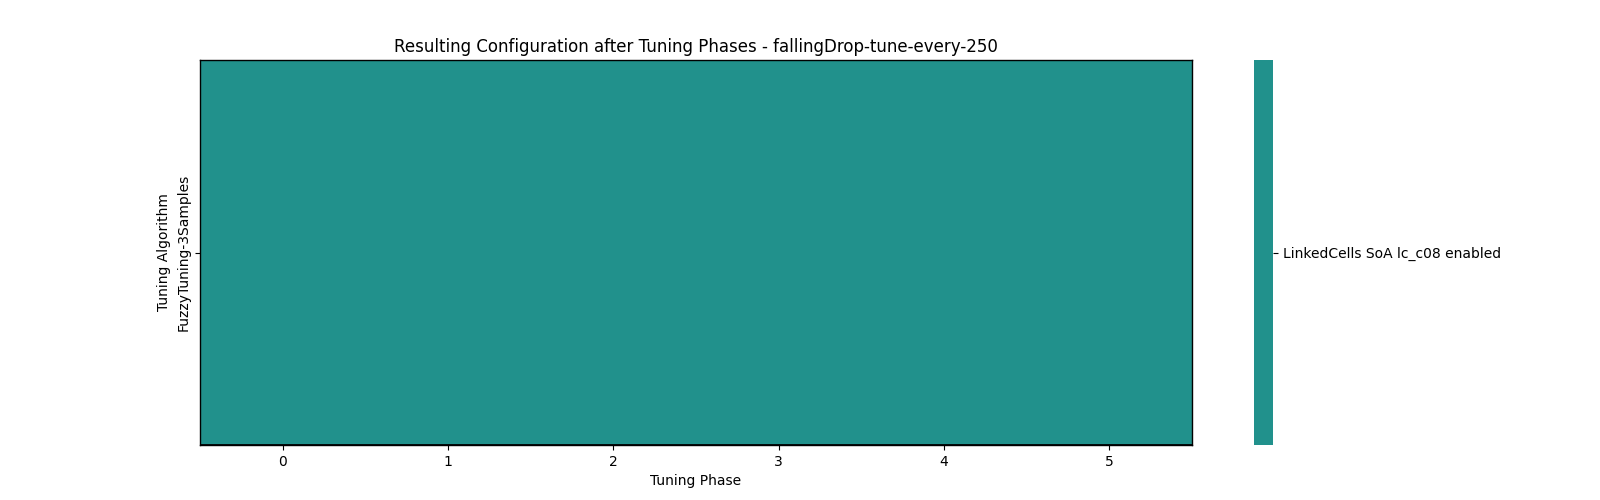

43
54
47
43
56
25


/tmp/ipykernel_409556/3609927937.py:43: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  sns.heatmap(df.replace(value_to_int).T, cmap=cmap, ax=ax)


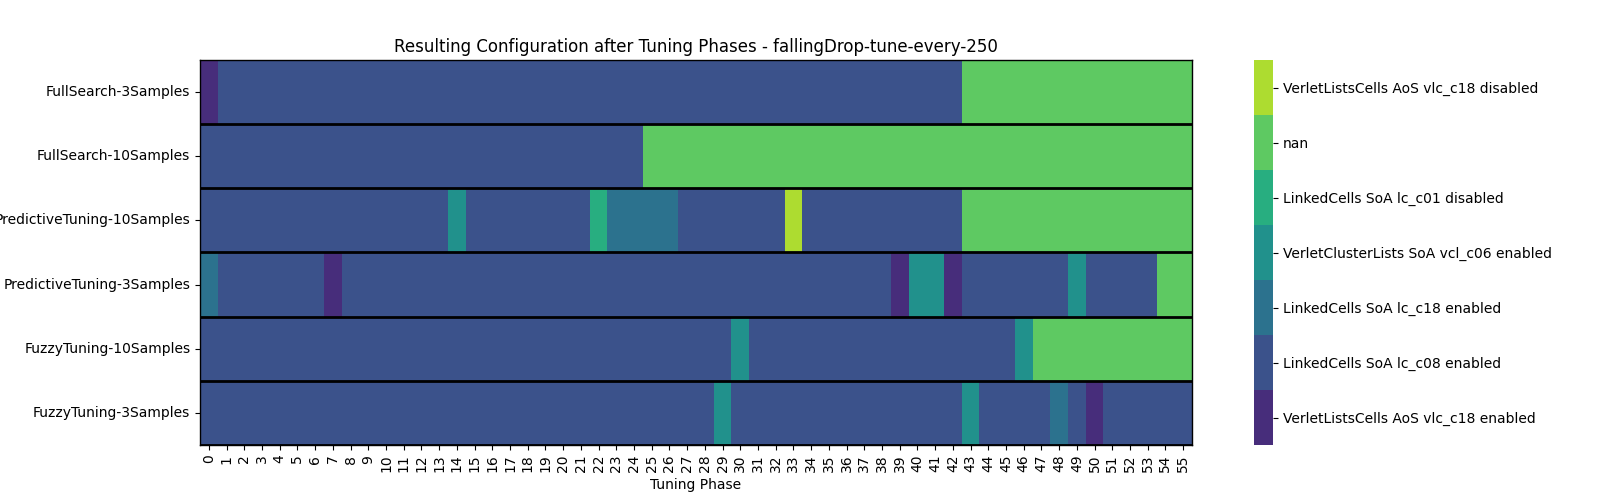

6
6
6
6
6


/tmp/ipykernel_409556/3609927937.py:43: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  sns.heatmap(df.replace(value_to_int).T, cmap=cmap, ax=ax)


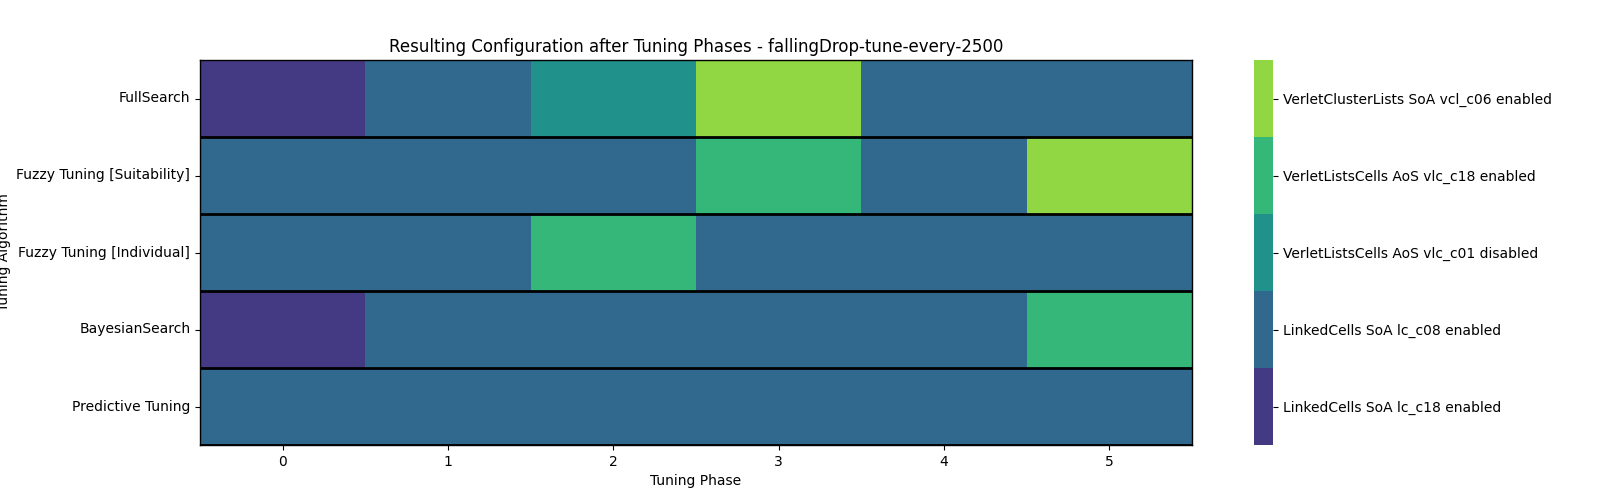

In [195]:

# TODO FIX THIS. THE ITERATION IS NOT CORRECTLY ALIGNED

for scenario, s_data in data.items():

    for ruleset, r_data in s_data.items():
        df_fullsearch = pd.DataFrame()
        df_tuners = pd.DataFrame()

        # sort by mean time spent calculating forces
        for tuning_algorithm, logs in r_data.items():
            tuning_results = logs["tuningResults"]

            iteration = tuning_results["Iteration"]
            container = tuning_results["Container"]
            datalayout = tuning_results["Data Layout"]
            traversal = tuning_results["Traversal"]
            newton3 = tuning_results["Newton 3"]

            combined = []
            for (i, iter) in iteration.items():
                comb = " ".join(
                    [container.iloc[i], datalayout.iloc[i], traversal.iloc[i], newton3.iloc[i]])
                combined.append(comb)

            total_config = pd.DataFrame(combined, columns=[tuning_algorithm])

            if "FullSearch" in tuning_algorithm:
                df_fullsearch = pd.concat(
                    [df_fullsearch, total_config], axis=1)
            else:
                df_tuners = pd.concat([df_tuners, total_config], axis=1)

        df = pd.concat([df_fullsearch, df_tuners], axis=1)

        fig, ax = plt.subplots(1, 1, figsize=(16, 5))

        value_to_int = {value: i for i, value in enumerate(
            pd.unique(df.values.ravel()))}

        n = len(value_to_int)
        cmap = sns.color_palette("viridis", n)

        sns.heatmap(df.replace(value_to_int).T, cmap=cmap, ax=ax)

        colorbar = ax.collections[0].colorbar
        r = colorbar.vmax - colorbar.vmin
        colorbar.set_ticks([colorbar.vmin + r / n * (0.5 + i)
                            for i in range(n)])
        colorbar.set_ticklabels(list(value_to_int.keys()))

        ax.set_title(
            f"Resulting Configuration after Tuning Phases - {scenario}")
        ax.set_xlabel("Tuning Phase")
        ax.set_ylabel("Tuning Algorithm")

        # set y label positon to the top left corner

        ax.spines['top'].set_visible(True)
        ax.spines['right'].set_visible(True)
        ax.spines['bottom'].set_visible(True)
        ax.spines['left'].set_visible(True)

        # set rotation of y labels
        # move y ticks a bit to the left

        # draw horizontal lines
        for i in range(1, len(df.index)):
            ax.axhline(i, color="black", lw=2)

        plt.show()